In [1306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
%matplotlib inline
%config InlineBackrnd.figure_format='svg'
matplotlib.rcParams.update({'font.size':12})

# Загрузка данных
__Описание датасета__

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [1307]:
DataSetPath="data/train.csv"
TestDataSetPath="data/test.csv"
train_df=pd.read_csv(DataSetPath)
test_df=pd.read_csv(TestDataSetPath)

## Проверка одинаковых столбцов в датафреймах

In [1308]:
np.array(train_df.columns)[:-1]==np.array(test_df.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Объединение датасетов для синхронности преобразований 

In [1309]:
df = pd.concat([train_df, test_df], axis=0)
df = df.reset_index(drop=True)

## Преобразование типов данных

In [1310]:
df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

Дальнейший анализ проводим по всему датафрему (test + train)

In [1311]:
df.Id=df.Id.astype(str)
df.DistrictId=df.DistrictId.astype(str)
x_train = df[df["Price"].notnull()]
x_test = df[df["Price"].isnull()]

# Обзор данных

__Целевая переменная__

C:\Users\ruchkinasa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\ruchkinasa\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


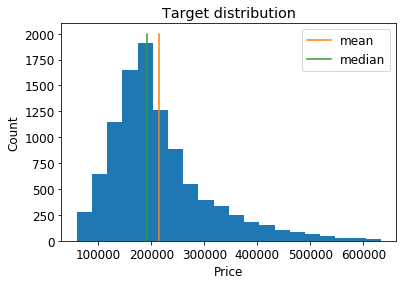

In [1312]:
plt.hist(df['Price'], bins=20)
plt.plot([df.Price.mean()]*100, np.linspace(0,2000,100), label='mean')
plt.plot([df.Price.median()]*100, np.linspace(0,2000,100), label='median')
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.legend()
plt.show()

__Вывод: выбросов нет, показатель распределен достаточно равномерно, с небольшим скосом в сторону более дешевых квартир__

## Количественные переменные

In [1313]:
df.describe(exclude='object')

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


__Вывод__
* Есть показатели, которые требуют обработки выбросов: Rooms, Square, LifeSquare, Floor, HouseFloor, Social_3(?)
* Есть показатели с пропущенными данными:LifeSquare, Healthcare_1

## Категориальные переменные

In [1314]:
x_train.describe(include='object')

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000,10000,10000
unique,10000,205,2,2,2
top,7208,27,B,B,B
freq,1,851,9903,9725,9175


__Вывод__: по показателям Ecology_2, Ecology_3 и Shop_2 все позиции в основном имеют категорию В из двух возможных.
Пропущенных значений нет

In [1315]:
x_test.describe(include='object')

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000,5000,5000
unique,5000,201,2,2,2
top,10077,27,B,B,B
freq,1,391,4952,4851,4588


__Вывод__: в тестовой выборке категория В также наиболее части встречается, но присутствует и вторая категория.
Пропущенных значений нет

## DistrictID
Посмотрим, какие регионы есть в тестовой выборке

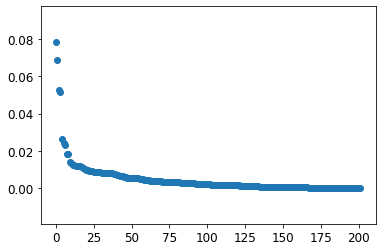

In [1316]:
a=x_test['DistrictId'].value_counts(normalize=True)
plt.scatter(np.linspace(0,len(a),len(a)),a)
plt.show()

In [1317]:
print(sum(x_test['DistrictId'].value_counts(normalize=True)[0:4]))
top_district_index=x_test['DistrictId'].value_counts(normalize=True)[0:4].index

0.25120000000000003


__Вывод__: В тестовой выборке 201 регион, но 25% всей тестовой выборки относятся к 4 регионам. Возможно стоит по ним рассмотреть индивидуальные модели.

__Оценим, есть ли по данным регионам значимое количество данных:__

In [1318]:
x_train['DistrictId'].value_counts().loc[top_district_index]

27    851
1     652
23    565
6     511
Name: DistrictId, dtype: int64

__Вывод__: по данным 4 регионам в обучающей выборке значимое количество данных (более 500 точек по каждой)

# Обработка выбросов

## * Rooms

In [1319]:
df[df.Rooms>=6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
12071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B,NaN
13217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B,NaN
13398,1435,111,17.0,52.866107,32.528342,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B,NaN


__Вывод__: Если количество комнат 6 и более это может быть ошибкой, а может и нет. Предлагается оценить среднее соотношение прощади квартиры и количества комнат. На основе этого соотношения определить количество комнат для некорректных данных

In [1320]:
room_square=(df[df.Rooms<=6].Square/df[df.Rooms<=6].Rooms).median()

In [1321]:
df.loc[(df.Rooms>=6) & (df.Square/df.Rooms<10),'Rooms']=\
        round(df.loc[(df.Rooms>=6) & (df.Square/df.Rooms<10),'Square']/room_square,0)

In [1322]:
df[df.Rooms>=6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
12071,10793,23,6.0,110.750226,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B,NaN
13217,4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B,NaN


__Вывод__: видно, что шестикомнатные квартиры (Room=6) остались только для квартир с большой площадью

## *HouseYear

In [1323]:
df.loc[df['HouseYear']>2030,'HouseYear']=df.HouseYear.median()
pd.cut(df['HouseYear'],bins=20).value_counts().sort_index()

(1907.888, 1913.6]       8
(1913.6, 1919.2]        18
(1919.2, 1924.8]         1
(1924.8, 1930.4]        23
(1930.4, 1936.0]        38
(1936.0, 1941.6]        31
(1941.6, 1947.2]         6
(1947.2, 1952.8]        29
(1952.8, 1958.4]       205
(1958.4, 1964.0]      1080
(1964.0, 1969.6]      1219
(1969.6, 1975.2]      1587
(1975.2, 1980.8]      4716
(1980.8, 1986.4]       822
(1986.4, 1992.0]       645
(1992.0, 1997.6]       488
(1997.6, 2003.2]       654
(2003.2, 2008.8]       689
(2008.8, 2014.4]       974
(2014.4, 2020.0]      1767
Name: HouseYear, dtype: int64

## *KitchenSquare

In [1324]:
pd.cut(df.KitchenSquare,bins=15).value_counts().sort_index()

(-2.014, 134.267]       14997
(134.267, 268.533]          0
(268.533, 402.8]            0
(402.8, 537.067]            0
(537.067, 671.333]          1
(671.333, 805.6]            0
(805.6, 939.867]            0
(939.867, 1074.133]         0
(1074.133, 1208.4]          0
(1208.4, 1342.667]          0
(1342.667, 1476.933]        0
(1476.933, 1611.2]          0
(1611.2, 1745.467]          0
(1745.467, 1879.733]        0
(1879.733, 2014.0]          2
Name: KitchenSquare, dtype: int64

Считаем кухни более 30 кв.м. аномальными выбросами. Заменим площадь кухни для таких случаев медианным значением.

In [1325]:
df.loc[df.KitchenSquare>30,'KitchenSquare']=df.KitchenSquare.median()

In [1326]:
pd.cut(df.KitchenSquare,bins=15).value_counts().sort_index()

(-0.03, 2.0]    4691
(2.0, 4.0]        93
(4.0, 6.0]      3466
(6.0, 8.0]      2818
(8.0, 10.0]     2893
(10.0, 12.0]     721
(12.0, 14.0]     171
(14.0, 16.0]      77
(16.0, 18.0]      26
(18.0, 20.0]      29
(20.0, 22.0]       5
(22.0, 24.0]       2
(24.0, 26.0]       3
(26.0, 28.0]       1
(28.0, 30.0]       4
Name: KitchenSquare, dtype: int64

В выборке большое число кухонь с явно некорректной площадью (менее 3 метров). Наидем показатель, на основании которого можно попытатьcя восстановить размер кухни для данных квартир:

In [1327]:
mask=(df.KitchenSquare>3)
df.loc[df.KitchenSquare>3].corr().KitchenSquare

Rooms            0.119387
Square           0.483997
LifeSquare       0.291646
KitchenSquare    1.000000
Floor            0.311484
HouseFloor       0.531473
HouseYear        0.567458
Ecology_1       -0.073060
Social_1        -0.116163
Social_2        -0.047023
Social_3        -0.041406
Healthcare_1    -0.100631
Helthcare_2     -0.102604
Shops_1         -0.031654
Price            0.287122
Name: KitchenSquare, dtype: float64

Попытаемся восстановить площадь кухни в зависимости от года постройки дома. Для усреднения всплесков агругируем данные по пятилеткам

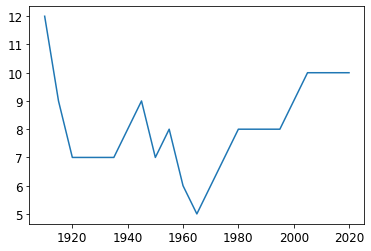

In [1328]:
kitchen_estimate=df[mask].groupby(round(df.HouseYear/5,0)*5).KitchenSquare.median()
plt.plot(kitchen_estimate)
plt.show()

Перенесем полученные оценки на точки с некорректными данными по площадам кухни:

In [1329]:
df=pd.merge(df, kitchen_estimate, how='inner', left_on=round(df.HouseYear/5,0)*5, right_index=True)

In [1330]:
df.loc[df.KitchenSquare_x<=3,'KitchenSquare_x']=df.KitchenSquare_y

In [1331]:
df=df.rename(columns={"KitchenSquare_x":"KitchenSquare"})

In [1332]:
df=df.drop(columns=['key_0','KitchenSquare_y'])

## * Sqare

__Выявляем квартиры с завышенной площадью__

Text(0, 0.5, 'Square')

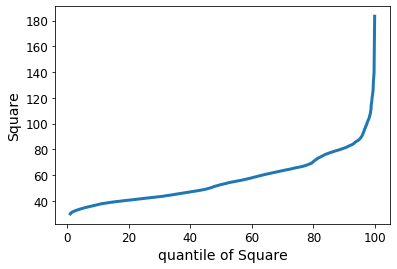

In [1333]:
q = [np.percentile(train_df["Square"], q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of Square", size=14)
plt.ylabel("Square", size=14)

__Вывод:__ видно, что квартиры с площадью более 150 метров имеет смысл проанализировать отдельно.

Просмотрим данные квартиры более подробно

In [1334]:
df[df["Square"]>150].Price

1812     190949.293998
2603     207007.956663
3260     217874.997452
4047     228572.520347
4262     187717.242538
6201     531049.721966
7084     194582.912756
8131     211180.794219
8646     211325.577641
8913     207407.352593
14384              NaN
1981     302211.260887
1982     455264.882666
3368     367353.574566
6451     559886.965348
7201     423443.464367
8511     345665.209100
13909              NaN
1641     232766.187698
4690      90470.430830
5087     340273.238253
9910     528560.506016
11264              NaN
11499              NaN
12039              NaN
12557              NaN
13217              NaN
4487     622888.825328
3651     200800.673767
6977     133529.681562
652      338644.075979
5444     502523.573863
2656     284884.959104
13253              NaN
Name: Price, dtype: float64

__Вывод__:
*  Есть 30 квартир (из них 8 в тестовом наборе) с  площадью более 150 метров. 
*  Для анализа их логичности посчитаем цену за квадратный метр и сравним с ценой за квадратный метр в данном районе

Добавляем показатели:
* __Price_for_metr__ - цена за квадратный метр данной квартиры
* __Price_for_metr_District__ - средняя цена за квадратный метр в данном регионе

In [1335]:
df['Price_for_metr']=df.Price/df.Square
price_district=df[(df["LifeSquare"]<150) & (df['Price'].notnull())].groupby(['DistrictId'])['Price_for_metr'].mean()
df['Price_for_metr_District']=df['DistrictId'].map(price_district.to_dict())

Добавим коэффициент соотношения цены за квадратный метр в данной квартире и в данном районе

In [1336]:
df['k']=df.Price_for_metr/df.Price_for_metr_District

Оценим, какое отклонение цены за квадратный метр от средней можно считать значимым:

In [1337]:
df.k.mean()-df.k.std()

0.29301414764513367

Заменим для квартир с заниженной ценой за квадратный метр площадь квартиры на рассчетную:

In [1338]:
mask=(df["Square"]>150) & (df['k']<0.29) & (df['Rooms']<5)
df.loc[mask,['Square']]=df.Price/df.Price_for_metr_District

__Выявляем квартиры с заниженной площадью (при ошибке такие квартиры должны иметь завышенную цену за квадратный метр)__

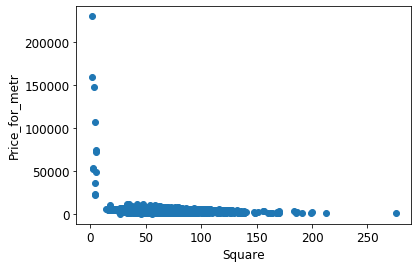

In [1339]:
plt.scatter(df.Square, df.Price_for_metr)
plt.xlabel('Square')
plt.ylabel('Price_for_metr')
plt.show()

__Вывод__: выделяется явный блок квартир с заниженной площадью, причем для них цена за квадратный метр сильно завышена.

Вариант 1: это особый тип недвижимости. Тогда имеет смысл рассмотреть их отдельно.

Вариант 2: это ошибка в данных. Рассмотрим гипотезу - ошибка на порядок. Восстановим данные для таких квартир

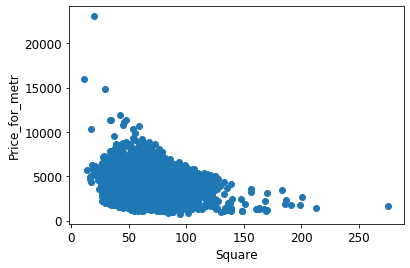

In [1340]:
df.loc[df["Square"]<6, "Square"]=df["Square"]*10
plt.scatter(df.Square, df.Price/df.Square)
plt.xlabel('Square')
plt.ylabel('Price_for_metr')
plt.show()

__Вывод__: от заниженных площадей мы избавились, но возможно имеет смысл вернуться к рассмотрению выбросов по показателю цены за квадратный метр

__Сравнение 'Square' и 'LifeSquare'__

При превышении жилой площади над общей площадью квартирызаменим площадь на максимальную: 

In [1341]:
df.loc[df.Square<df.LifeSquare, 'Square']=df.LifeSquare

## * LifeSquare

Рассмотрим квартиры с завышенной жилой площадью

In [1342]:
LifeSquareHigh=df.LifeSquare.mean()+2*df.LifeSquare.std()
df[df.LifeSquare>LifeSquareHigh]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_for_metr,Price_for_metr_District,k
590,14990,23,2.0,263.542020,263.542020,5.0,6,5.0,1972.0,0.075779,...,1437,3,NaN,0,2,B,141780.231857,2926.328235,2177.029497,1.344184
10410,11533,94,2.0,303.071094,303.071094,6.0,5,12.0,1974.0,0.521867,...,6149,0,NaN,0,0,B,NaN,NaN,4168.659674,NaN
1981,7917,27,0.0,212.932361,211.231125,10.0,2,3.0,2008.0,0.211401,...,1892,0,NaN,0,1,B,302211.260887,1419.282909,3040.333818,0.466818
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011.0,0.161976,...,7010,5,4508.0,3,7,B,455264.882666,1651.633128,4830.045482,0.341950
4328,16550,27,3.0,7480.592129,7480.592129,10.0,9,17.0,2016.0,0.017647,...,469,0,NaN,0,0,B,217357.492366,2660.616239,3040.333818,0.875107
4690,2307,102,1.0,410.639749,410.639749,10.0,4,4.0,2016.0,0.238617,...,3889,6,705.0,3,6,B,90470.430830,220.969386,3363.968996,0.065687
9910,16568,27,4.0,201.627361,201.627361,25.0,1,2.0,2013.0,0.041116,...,14892,4,NaN,1,4,B,528560.506016,2638.389304,3040.333818,0.867796
8437,15886,85,3.0,461.463614,461.463614,10.0,12,16.0,1998.0,0.037178,...,11217,1,2300.0,1,7,B,394253.299978,5050.687689,4200.086208,1.202520
6977,11602,30,2.0,638.163193,638.163193,10.0,20,19.0,2019.0,0.000078,...,6398,141,1046.0,3,23,B,133529.681562,208.293451,2948.218257,0.070651


__Вывод__: сравнение показателя Square и LifeSquare для квартир с завышенной жилой площадью показывает на вероятную ошибку на порядок или два порядка при вводе жилой площади. Используем это сравнение для восстановления корректных цифр жилой площади.

In [1343]:
df.loc[df.LifeSquare/df.Square>20, 'LifeSquare']=df.LifeSquare/100
df.loc[df.LifeSquare/df.Square>2, 'LifeSquare']=df.LifeSquare/10

__Для пропусков значений LifeSquare__ используем формулу: 

Square-KitchenSquare - медианное значение площади вспомогательных помещений (HelpSquare)

Формула расчета нового признака HelpSquare:


HelpSquare=Square-KitchenSquare-LifeSquare

In [1344]:
df.loc[df['LifeSquare'].notnull(),'HelpSquare']=df['Square']-df['LifeSquare']-df['KitchenSquare']

Проверим количество квартир, для которых Square<LifeSquare+KitchenSquare

In [1345]:
df[df.HelpSquare<0].HelpSquare.count()

1838

__Промежуточный вывод__: обнаружено более 1000 квартир с некорректным расчетом жилой площади. 

In [1346]:
help_square_median=df[df.HelpSquare>0].HelpSquare.median()
help_square_median

12.512039041417424

Заполним пропуски и исправим некорректные значения жилой площажи на оценочные:

In [1347]:
df.loc[(((df.HelpSquare.isnull()) | (df.HelpSquare<0)) & (df.Square>15)),'HelpSquare']=help_square_median

In [1348]:
df.loc[df.LifeSquare.isnull(),'LifeSquare']=df['Square']-df['HelpSquare']-df['KitchenSquare']
df.loc[df.LifeSquare<0,'LifeSquare']=0

## * Price_for_metr

Обновим показатель цены за метр и проанализируем его разброс

In [1349]:
df['Price_for_metr']=df.Price/df.Square
df['k']=df.Price_for_metr/df.Price_for_metr_District
pd.cut(df['k'],bins=20).value_counts().sort_index()

(0.00553, 0.211]      11
(0.211, 0.412]       177
(0.412, 0.614]       401
(0.614, 0.815]      1434
(0.815, 1.016]      4147
(1.016, 1.218]      2979
(1.218, 1.419]       694
(1.419, 1.62]        113
(1.62, 1.822]         28
(1.822, 2.023]         9
(2.023, 2.224]         2
(2.224, 2.426]         0
(2.426, 2.627]         1
(2.627, 2.829]         1
(2.829, 3.03]          0
(3.03, 3.231]          0
(3.231, 3.433]         1
(3.433, 3.634]         1
(3.634, 3.835]         0
(3.835, 4.037]         1
Name: k, dtype: int64

Удалим квартиры с ценой за метр, более чем вдвое превышающие среднюю цену за метр в данном районе

In [1350]:
df=df[(df['k']<2) | df['k'].isnull()]

Повторим рассмотрение полученного соотношения. 

In [1351]:
pd.cut(df['k'],bins=20).value_counts().sort_index()

(0.00762, 0.107]       3
(0.107, 0.204]         5
(0.204, 0.301]        46
(0.301, 0.398]       101
(0.398, 0.495]       136
(0.495, 0.592]       220
(0.592, 0.689]       387
(0.689, 0.786]       783
(0.786, 0.883]      1468
(0.883, 0.98]       2167
(0.98, 1.077]       2063
(1.077, 1.174]      1363
(1.174, 1.271]       723
(1.271, 1.368]       285
(1.368, 1.465]       139
(1.465, 1.562]        55
(1.562, 1.659]        20
(1.659, 1.756]        16
(1.756, 1.853]         5
(1.853, 1.95]          7
Name: k, dtype: int64

Удалим квартиры с заниженной ценой за квадратный метр

In [1352]:
df=df[(df['k']>0.16)| df['k'].isnull()]

Посмотрим на полученные распределения цен:

In [1353]:
# df=df.loc[(df['Price_for_metr']<12000) | df['Price_for_metr'].isnull()]
pd.cut(df['Price_for_metr'],bins=10).value_counts().sort_index()

(526.663, 1669.647]        240
(1669.647, 2801.314]      1893
(2801.314, 3932.982]      2943
(3932.982, 5064.649]      3366
(5064.649, 6196.316]      1190
(6196.316, 7327.984]       278
(7327.984, 8459.651]        57
(8459.651, 9591.318]        15
(9591.318, 10722.986]        3
(10722.986, 11854.653]       4
Name: Price_for_metr, dtype: int64

__Добавим признак первого/вторго/последнего этажа__

In [1354]:
# # добавим показатель цены за квадратный метр для выявления влияния других факторов
# df['Price_1m']=df['Price']/df['Square']

# df['TypeFloor']='middle'
# df.loc[df.HouseFloor==df.Floor,'TypeFloor']='last'
# df.loc[df.Floor==1,'TypeFloor']='first'
# df.loc[df.Floor==2,'TypeFloor']='second'
# добавим показатель медианной стоимости в районе

__Преобразуем категориальные переменные в дамми переменные__

In [1355]:
df['Ecology_2'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2'] = train_df['Shops_2'].replace({'A':0, 'B':1})

Для регионов, отсутствующих в тестовой выборке, установим медианное значение Price_for_metr_District

In [1356]:
price_median=df.Price_for_metr_District.median()
df.loc[df.Price_for_metr_District.isnull(),'Price_for_metr_District']=price_median

Для показателя отсутствующих значений Healthcare_1 установим медианное значение Healthcare_1

In [1357]:
df.loc[df.Healthcare_1.isnull(), 'Healthcare_1']=df.Healthcare_1.median()

In [1358]:
df[df.Price.isnull() & df.Id.isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Price_for_metr,Price_for_metr_District,k,HelpSquare


Приверим, все ли пропуски восстановлены:

In [1359]:
df.count()

Id                         14989
DistrictId                 14989
Rooms                      14989
Square                     14989
LifeSquare                 14989
KitchenSquare              14989
Floor                      14989
HouseFloor                 14989
HouseYear                  14989
Ecology_1                  14989
Ecology_2                   9989
Ecology_3                   9989
Social_1                   14989
Social_2                   14989
Social_3                   14989
Healthcare_1               14989
Helthcare_2                14989
Shops_1                    14989
Shops_2                     9989
Price                       9989
Price_for_metr              9989
Price_for_metr_District    14989
k                           9989
HelpSquare                 14989
dtype: int64

Обновим x_train, x_test

In [1360]:
x_train = df[df["Price"].notnull()]
x_test = df[df["Price"].isnull()]

# Отбор признаков

In [1361]:
feature_names=[
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
#  'Ecology_2',
#  'Ecology_3',
#  'Shops_2',
#  'first',
#  'last',
#  'middle',
#  'second',
    'Price_for_metr_District'
#  ,'median_price_1m' 
]
target_name = 'Price'

# Стандартизация признаков

In [1362]:
# feature_names_for_stand = df[feature_names].select_dtypes(include=['float64','int64']).columns.tolist()
# feature_names_for_stand
# scaler = StandardScaler()
# stand_features = scaler.fit_transform(df[feature_names_for_stand])
# df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

# Разбиение на train и test

In [1363]:
X = x_train[feature_names]
y = x_train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=15)

In [1364]:
y_valid.shape

(3297,)

# Построение базовых моделей и выбор лучшей¶

In [1365]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sb.scatterplot(x=pred_values, y=true_values)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             color="red", linestyle="--", alpha=0.5, linewidth=3)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

# Gradient Boosting

In [1366]:
# y_valid_preds = gb_model.predict(X_valid)
# evaluate_preds(y_valid, y_valid_preds)

# Настройка и оценка финальной модели

In [1367]:
# gb_model = GradientBoostingRegressor(random_state=21)
# gb_model
# params = {'n_estimators':[50, 80,110,150], 
#           'max_depth': [3, 5,7,9]}

# gs = GridSearchCV(
#     gb_model, 
#     params, 
#     scoring='r2', 
#     cv=KFold(n_splits=5, random_state=21, shuffle=True),
#     n_jobs=-1
# )
# gs.fit(X, y)
# gs.best_params_

In [1368]:
final_model = GradientBoostingRegressor(n_estimators=150, max_depth=3, random_state=21)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.808


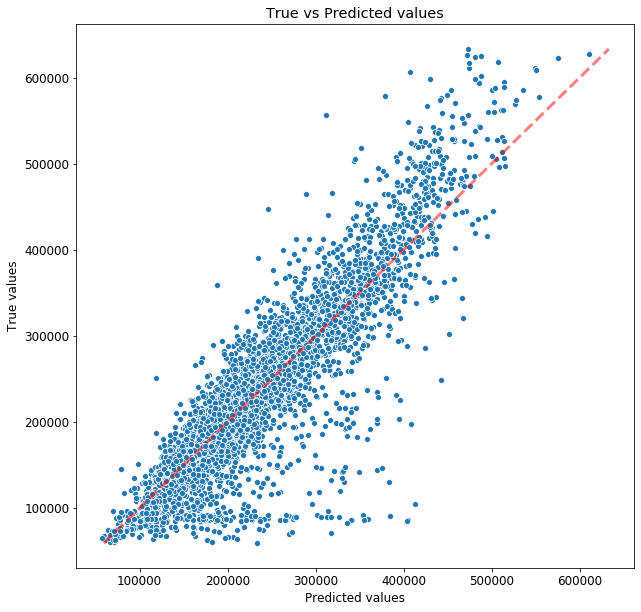

In [1369]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.756


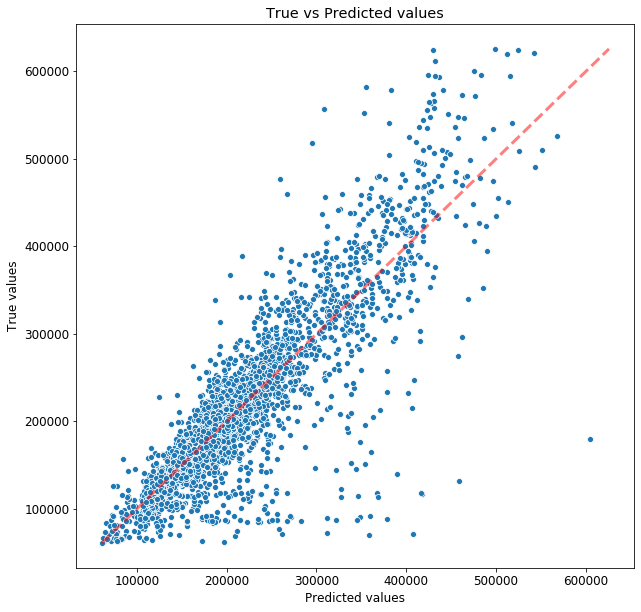

In [1370]:
y_valid_preds = final_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

In [1371]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.486401
14,Price_for_metr_District,0.386297
6,HouseYear,0.025365
0,Rooms,0.023022
9,Social_2,0.013564
10,Social_3,0.012485
5,HouseFloor,0.009014
3,KitchenSquare,0.008297
11,Healthcare_1,0.007310
4,Floor,0.006789


In [1372]:
base_score=r2(y_valid, final_model.predict(X_valid))
print('base_score')
for feature in feature_names:
    X_valid1=X_valid.copy()
    X_valid1[feature] = np.random.permutation(X_valid1[feature])
    score=r2(y_valid, final_model.predict(X_valid1))
    print(feature, ': score', '-','base_score','=',round(score-base_score,3))
    

base_score
Rooms : score - base_score = -0.007
Square : score - base_score = -0.726
LifeSquare : score - base_score = -0.001
KitchenSquare : score - base_score = -0.003
Floor : score - base_score = -0.006
HouseFloor : score - base_score = -0.014
HouseYear : score - base_score = -0.024
Ecology_1 : score - base_score = -0.005
Social_1 : score - base_score = -0.006
Social_2 : score - base_score = -0.005
Social_3 : score - base_score = -0.015
Healthcare_1 : score - base_score = -0.003
Helthcare_2 : score - base_score = -0.001
Shops_1 : score - base_score = -0.0
Price_for_metr_District : score - base_score = -0.488


__Вывод:__ все параметры в модели значимы, исключение нецелессобразно

In [1373]:
y_test_predict=final_model.predict(x_test[feature_names])

In [1374]:
y_itog = pd.DataFrame(zip(x_test.Id, y_test_predict), 
                                   columns=['Id', 'Price'])
y_itog.to_csv('SRuchkina_predictions.csv', index=False)